In [1]:
import slicetca
import torch
import numpy as np
import pandas as pd
import pickle
import scipy.ndimage as spnd
import scipy.stats as sps
import matplotlib.pyplot as plt
import matplotlib
import gdown

from functions import *

In [ ]:
dir = '/Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT'
dir2 = '/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/Data_Sample'
subjects = ['BCOM_18_2', 'BCOM_18_3', 'BCOM_18_4']
picks=['MEG 130', 'MEG 139','MEG 133','MEG 117','MEG 140','MEG 127','MEG 128','MEG 109','MEG 135','MEG 132','MEG 137',
 'MEG 131','MEG 129','MEG 118','MEG 134','MEG 136','MEG 141','MEG 116','MEG 114','MEG 115']

picks = None

data_dict = data_load(dir, subjects, picks, avoid_reading=True)

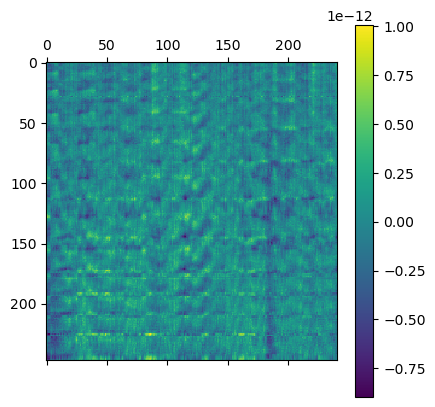

In [21]:
plt.matshow(data_dict['BCOM_18_4']['i_116'][0]) #Ok actually, the data does have negative values, so can't do naive NMF here
plt.colorbar()

In [5]:
data_dict['BCOM_18_2'].keys()

dict_keys(['re_144', 'i_116', 'a_112', 'ri_146', 'sa_152', 'ma_132', 'ra_142', 'te_164', 'si_156', 'li_126', 'ta_162', 'ti_166', 'e_114', 'mi_136', 'se_154', 'la_122', 'me_134', 'le_124'])

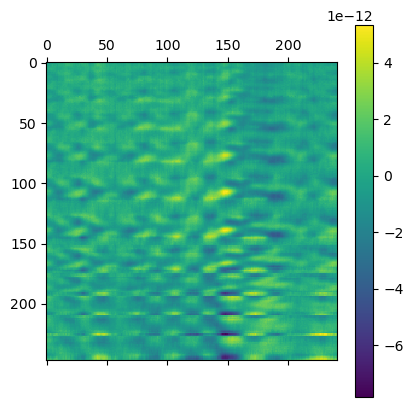

In [44]:
# she suggested I look at the avearge of the data - it looks like there are some trends actually, but if they're trends everywhere they will be hard to separate

means = {}
sums = np.zeros([247, 241])
for subject in data_dict:
    for syllable in data_dict[subject]:
        for epoch in data_dict[subject][syllable]:
            sums += epoch
        mean = sums / len(data_dict[subject][syllable])
        means[syllable] = mean

plt.matshow(means['ma_132'])
plt.colorbar()

### Pre-Function work

In [63]:
device = "mps"
concatenated = np.array([])

# so, since we have different depths, numpy doesn't want to concatenate them smh. We will have to be clever
lengths = get_syllable_counts(data_dict)
max_length = get_max_length(lengths)

In [4]:
sliced_data_dict = {}

for key in data_dict:
    sliced_data_dict[key] = {}
    for syllable in data_dict[key]:
        sliced_data_dict[key][syllable] = []
        for epoch in data_dict[key][syllable]:
            sliced_data_dict[key][syllable].append(epoch[:, 70:150])
        sliced_data_dict[key][syllable] = np.array(sliced_data_dict[key][syllable])    

In [4]:
#padding
x = data_dict.copy()
for subject in x:
    for syllable in data_dict[subject]:
        if len(data_dict[subject][syllable]) < max_length[subject]: # if the length is smaller than the max length
            padding = np.zeros([max_length[subject] - len(data_dict[subject][syllable]), 20, 241]) # create a padding array
            data_dict[subject][syllable] = np.concatenate((data_dict[subject][syllable], padding)) # concatenate the padding to the original array

#concatenating
concatenated = np.zeros((0, 20, 241)) # create an empty array to concatenate the data to
for subject in data_dict: # for each subject
    for syllable in data_dict[subject]: # for each syllable
            concatenated = np.concatenate((concatenated, data_dict[subject][syllable]), axis=0) # concatenate the data to the empty array
concatenated.shape

(324, 20, 241)

In [5]:
padding_array = np.zeros([20, 241])


index_list = []
i = -1
for slice in concatenated:
    i += 1
    if np.array_equal(slice, padding_array):
        index_list.append(i)
index_list
concatenated = np.delete(concatenated, index_list, axis=0)
concatenated = concatenated.astype(np.float32)
# remove_padding(concatenated).shape
concatenated.shape

(203, 20, 241)

In [6]:
x = torch.tensor(concatenated, dtype=torch.float32, device=device)

### Functionalized

In [49]:
trial_1, trial_2, trial_3 = {}, {}, {}
trial_1['BCOM_18_2'] = data_dict['BCOM_18_2']
trial_2['BCOM_18_3'] = data_dict['BCOM_18_3']
trial_3['BCOM_18_4'] = data_dict['BCOM_18_4']

False

In [50]:
# MEG_DATA_TENSOR, idxs = data_to_tensor(sliced_data_dict, rows=247, columns=80)
MEG_DATA_TENSOR, idxs = data_to_tensor(trial_3, rows=247)

MEG_DATA_TENSOR = MEG_DATA_TENSOR

device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))

In [6]:
grid, seed = slicetca.grid_search(MEG_DATA_TENSOR.cpu(), max_ranks=(2,2,2), min_ranks=(1,0,0))

Grid shape: [2, 3, 3] - Samples: 1 - Grid entries: 18 - Number of models to fit: 18


Number of components (completed): (1, 2, 2) : 100%|██████████| 18/18 [01:54<00:00,  6.37s/it]


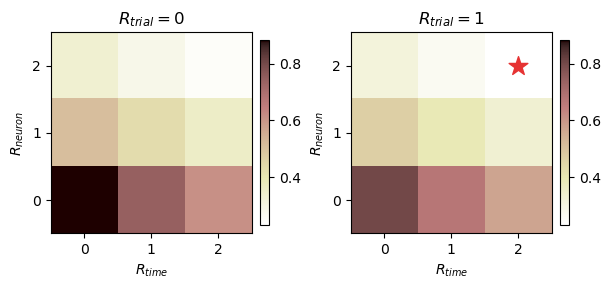

In [7]:
slicetca.plot_grid(grid)

In [ ]:
# MEG_DATA_TENSOR = MEG_DATA_TENSOR/MEG_DATA_TENSOR.std()

In [33]:
components, model = slicetca.decompose(MEG_DATA_TENSOR,
                                       number_components=(2,2,1),
                                       positive=False,
                                       learning_rate=5*10**-3,
                                       min_std=10**-5,
                                       max_iter=10000,
                                       seed=0)

The model converged. Loss: 0.4700753688812256 :  17%|█▋        | 1668/10000 [00:46<03:52, 35.90it/s]


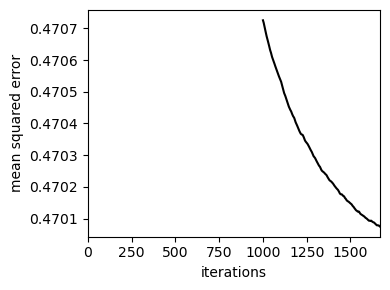

In [34]:
plt.figure(figsize=(4,3), dpi=100)
plt.plot(np.arange(1000,len(model.losses)), model.losses[1000:], 'k')
plt.xlabel('iterations')
plt.ylabel('mean squared error')
plt.xlim(0,len(model.losses))
plt.tight_layout()

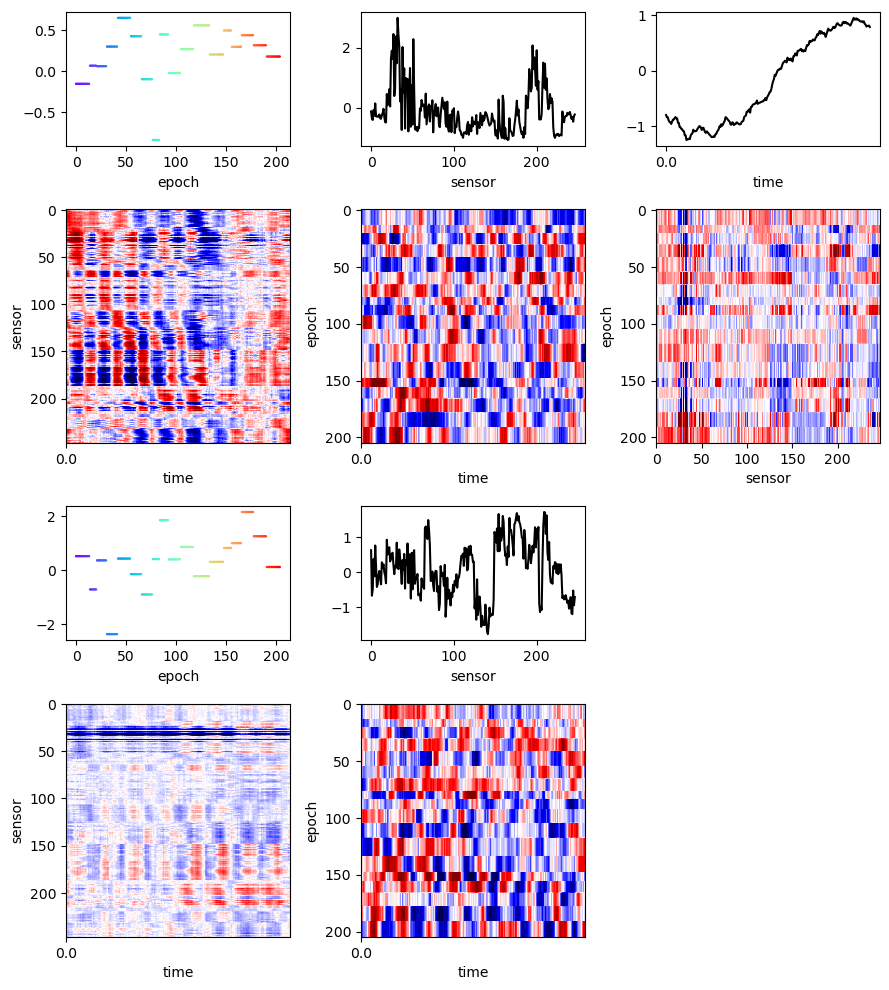

In [35]:
# we sort the neurons of the trial slices according to their peak activity in the first slice.
cmap = matplotlib.colormaps.get_cmap('rainbow')
trial_colors = np.array([cmap(i / len(idxs)) for i in range(len(idxs))])

sensor_sorting_peak_time = np.argsort(np.argmax(components[0][1][0], axis=1))

axes = slicetca.plot(model,
              variables=('epoch', 'sensor', 'time'),
              colors=[trial_colors, None, None], # we only want the trials to be colored
              ticks=(None, None, np.linspace(0, 80, 1)), # we only want to modify the time ticks
              tick_labels=(None, None, np.linspace(0, 80, 1)),
              sorting_indices=(np.array(idxs), sensor_sorting_peak_time, None),
              quantile=0.99,
              s = 0.5,
              dpi=100)

plt.savefig('sj18_trial3.png')


In [100]:
pd.read_csv('/Volumes/@neurospeech/PROJECTS/BCI/BCOM/PROTOCOL/trigger_labels.csv', delimiter=';')

,syllable,read_head,read_transition,produce_head,produce_transition
0,a,12,524,112,624
1,e,14,526,114,626
2,i,16,528,116,628
3,la,22,534,122,634
4,le,24,536,124,636
5,li,26,538,126,638
6,ma,32,544,132,644
7,me,34,546,134,646
8,mi,36,548,136,648
9,ra,42,554,142,654
